In [ ]:
# Homework4 Project
# Zhuxin (Edward) Hu 

import pandas as pd
import numpy as np
import category_encoders as ce
from xgboost import XGBClassifier
from pdpbox import pdp, info_plots
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from pandas.core.reshape.merge import merge

import plotly.express as px
import plotly.offline as off
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
# this line helps render plotly charts inside jupyter notebooks if they're not running
off.init_notebook_mode()

# suppress warning messages
import warnings
warnings.filterwarnings("ignore")

Homework4 Project
I will use Amazon Pricing Data for this project.

In [131]:
url = r"../../Unit4/data/Amazon-Ranking-Analysis.csv"
df = pd.read_csv(url)

#df = pd.read_csv(r"https://raw.githubusercontent.com/JonathanBechtel/dat-02-22/main/ClassMaterial/Unit3/data/ks2.csv")

Part 1 Data Preparation

In [132]:
df.head()

Index                                        ProductName  ScrapeDate  \
0      0  #1 BEST Probiotic Supplement - 60 Day Supply w...  2016-06-14   
1      1  #1 BEST Probiotic Supplement - 60 Day Supply w...  2016-06-14   
2      2  10 Panel Dip Drug Testing Kit, Test for 10 Dif...  2016-06-27   
3      3  10 Panel Dip Drug Testing Kit, Test for 10 Dif...  2016-06-27   
4      4  10 Panel Dip Drug Testing Kit, Test for 10 Dif...  2016-06-27   

   ScrapedIndex  ScrapedIndexTrueRank  CorrectedIndexTrueRank  \
0             2                     2                       1   
1             1                     1                       2   
2             1                     1                       1   
3             2                     1                       1   
4             3                     1                       1   

   ScrapedIndexPrice  CorrectedPrice   ScrapedIndexVendor  \
0              20.99           20.99  Supplement Warriors   
1              19.99           25.02      Sharp Nutrition   
2               3.96            3.96         speedy tests   
3               3.96            3.96   Drug Abuse Control   
4               3.96            3.96  Lowest Priced Tests   

  ScrapedIndexVendorType  BBScrapedPrice BBVendorType  \
0                  Other            -1.0          FBA   
1                    FBA            -1.0          FBA   
2                  Other             4.9          FBA   
3                  Other             4.9          FBA   
4                  Other             4.9          FBA   

                                           BBVendor  BBCorrectedPrice  
0  Sold by Sharp Nutrition and Fulfilled by Amazon.             25.02  
1  Sold by Sharp Nutrition and Fulfilled by Amazon.             25.02  
2  Sold by Michael Minyety and Fulfilled by Amazon.              9.97  
3  Sold by Michael Minyety and Fulfilled by Amazon.              9.97  
4  Sold by Michael Minyety and Fulfilled by Amazon.              9.97

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6973 entries, 0 to 6972
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Index                   6973 non-null   int64  
 1   ProductName             6973 non-null   object 
 2   ScrapeDate              6973 non-null   object 
 3   ScrapedIndex            6973 non-null   int64  
 4   ScrapedIndexTrueRank    6973 non-null   int64  
 5   CorrectedIndexTrueRank  6973 non-null   int64  
 6   ScrapedIndexPrice       6973 non-null   float64
 7   CorrectedPrice          6973 non-null   float64
 8   ScrapedIndexVendor      6973 non-null   object 
 9   ScrapedIndexVendorType  6973 non-null   object 
 10  BBScrapedPrice          6973 non-null   float64
 11  BBVendorType            6973 non-null   object 
 12  BBVendor                6809 non-null   object 
 13  BBCorrectedPrice        6973 non-null   float64
dtypes: float64(4), int64(4), object(6)
memor

In [134]:
df.corr(method='spearman')[['CorrectedPrice']].sort_values(by = 'CorrectedPrice')

CorrectedPrice
Index                        -0.081851
ScrapedIndexTrueRank          0.192314
ScrapedIndex                  0.212351
CorrectedIndexTrueRank        0.220608
BBScrapedPrice                0.813552
BBCorrectedPrice              0.889549
ScrapedIndexPrice             0.994012
CorrectedPrice                1.000000

In [135]:
df.corr(method='spearman')[['CorrectedIndexTrueRank']].sort_values(by = 'CorrectedIndexTrueRank')

CorrectedIndexTrueRank
Index                                -0.046739
BBCorrectedPrice                     -0.008134
BBScrapedPrice                        0.021942
CorrectedPrice                        0.220608
ScrapedIndexPrice                     0.229896
ScrapedIndex                          0.908636
ScrapedIndexTrueRank                  0.922519
CorrectedIndexTrueRank                1.000000

In [115]:
px.histogram(df['CorrectedPrice'])

In [139]:
px.histogram(df['ScrapedIndexPrice'])

In [121]:
px.histogram(0.5*(df['CorrectedPrice']))

In [117]:
px.histogram(np.sqrt(df['CorrectedPrice']))

In [118]:
px.histogram(np.log(df['CorrectedPrice']))

In [140]:
px.histogram(5*np.log(df['CorrectedPrice']))

In [119]:
px.histogram(3.5*np.log(df['CorrectedPrice']))

In [163]:
# Transform the y values from contiuous numbers into integers
df['Price_Index'] = np.round(3.5*np.log(df['CorrectedPrice']))
df['Index_1'] = df['Index']
df['Price_Index'].unique()

array([11.,  5.,  7.,  8.,  9., 12., 13., 14., 10., 15., 16., 17., 18.,
       19., 20., 22., 23.,  3.,  4.,  6., 21., 24.])

In [164]:
y1 = df['Price_Index']
px.histogram(y1)

In [138]:
df.corr(method='spearman')[['CorrectedPrice']].sort_values(by = 'CorrectedPrice')

CorrectedPrice
Index                        -0.081851
Index_1                      -0.081851
ScrapedIndexTrueRank          0.192314
ScrapedIndex                  0.212351
CorrectedIndexTrueRank        0.220608
BBScrapedPrice                0.813552
BBCorrectedPrice              0.889549
Price_Index                   0.993554
ScrapedIndexPrice             0.994012
CorrectedPrice                1.000000

Part 2 Model Building

In [61]:
#helper functions
def split_data(df, split_frac=0.2, random_state=42):
    #df = df.drop(['deadline', 'launched'], axis = 1)#remember to drop date columns
    df  = df.drop(['ScrapedIndexPrice', 'BBCorrectedPrice', 'BBScrapedPrice', 'ScrapeDate'], axis=1)
    X   = df.drop(['Price_Index', 'CorrectedPrice'], axis=1)
    y  = df['Price_Index']
    # notice the use of 'stratify' -- makes sure y values are in equal proportions in train + test important for classification data sets
    return train_test_split(X, y, test_size = split_frac, stratify = y, random_state = random_state)

# helper function to pull out feature importances_
def get_feature_importances(pipe, X_train, onehot=False):
    if onehot:
        X_train = pipe[0].transform(X_train)
        X_train = pipe[1].transform(X_train)
    return pd.DataFrame({
        'Col': X_train.columns,
        'Importance': pipe[-1].feature_importances_
    }).sort_values(by='Importance', ascending=False)


In [65]:
def get_model_scores(mod, X_train, y_train, X_test, y_test, val_score = True, test_score=False):
    if val_score:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          stratify = y_train, 
                                                          random_state= 42)
 
    mod.fit(X_train, y_train)
    
    results = {}
    
    results['train_score'] = mod.score(X_train, y_train)
    if val_score:
        results['val_score'] = mod.score(X_val, y_val)
        
    if test_score:
        results['test_score'] = mod.score(X_test, y_test)
        
    return results

In [76]:
#split data
X_train, X_test, y_train, y_test = split_data(df)

te = ce.TargetEncoder(min_samples_leaf = 30)

mod = XGBClassifier(eval_metric = 'logloss')

pipe3 = make_pipeline(te, mod)

scores = get_model_scores(pipe3, X_train, y_train, X_test, y_test, test_score = True)

scores

{'train_score': 0.9977588525324966,
 'val_score': 0.8333333333333334,
 'test_score': 0.8437275985663082}

In [132]:
#val score says cclassifier will get the right answer about 68.5% of the time

In [79]:

type(y_train)

pandas.core.series.Series

In [80]:
type(y_test)

pandas.core.series.Series

In [81]:
feats = get_feature_importances(pipe3, X_train)
feats

Col  Importance
1             ProductName    0.334454
4  CorrectedIndexTrueRank    0.131655
8                BBVendor    0.117315
7            BBVendorType    0.096290
0                   Index    0.095973
2            ScrapedIndex    0.061455
3    ScrapedIndexTrueRank    0.055336
6  ScrapedIndexVendorType    0.054573
5      ScrapedIndexVendor    0.052949
9                 Index_1    0.000000

In [82]:
ore = ce.OrdinalEncoder()

pipe1 = make_pipeline(ore, mod)

scores = get_model_scores(pipe1, X_train, y_train, X_test, y_test, test_score = True)

scores

{'train_score': 0.9991035410129987,
 'val_score': 0.8261648745519713,
 'test_score': 0.8186379928315413}

In [83]:
feats = get_feature_importances(pipe1, X_train)
feats

Col  Importance
0                   Index    0.159403
8                BBVendor    0.159137
1             ProductName    0.149868
4  CorrectedIndexTrueRank    0.127263
7            BBVendorType    0.119303
2            ScrapedIndex    0.089836
6  ScrapedIndexVendorType    0.081448
3    ScrapedIndexTrueRank    0.074709
5      ScrapedIndexVendor    0.039033
9                 Index_1    0.000000

In [84]:
ohe = ce.OneHotEncoder()

pipe2 = make_pipeline(ore, mod)

scores = get_model_scores(pipe2, X_train, y_train, X_test, y_test, test_score = True)

scores

{'train_score': 0.9991035410129987,
 'val_score': 0.8261648745519713,
 'test_score': 0.8186379928315413}

In [85]:
feats = get_feature_importances(pipe2, X_train)
feats

Col  Importance
0                   Index    0.159403
8                BBVendor    0.159137
1             ProductName    0.149868
4  CorrectedIndexTrueRank    0.127263
7            BBVendorType    0.119303
2            ScrapedIndex    0.089836
6  ScrapedIndexVendorType    0.081448
3    ScrapedIndexTrueRank    0.074709
5      ScrapedIndexVendor    0.039033
9                 Index_1    0.000000

In [87]:
pred3 = pipe3.predict(X_train)
pred3


array([13., 12.,  9., ..., 13., 11., 10.])

In [105]:
pred_prob3 = pipe3.predict_proba(X_train)
pred_prob3

array([[1.0489462e-03, 8.4547437e-04, 1.8621991e-04, ..., 6.7420915e-04,
        6.1177718e-03, 2.5391846e-03],
       [1.4235560e-03, 6.1427872e-03, 1.2714684e-03, ..., 1.6592082e-03,
        1.0634367e-02, 3.7771272e-03],
       [6.4308551e-04, 1.2220960e-03, 1.8498320e-04, ..., 6.5165898e-04,
        4.8040310e-03, 1.6993980e-03],
       ...,
       [4.0254910e-03, 5.6793675e-04, 1.3530342e-04, ..., 7.4297859e-04,
        4.1974910e-02, 9.5784548e-04],
       [1.8244065e-04, 2.1466216e-04, 2.8682553e-05, ..., 8.8105320e-05,
        9.4229035e-04, 4.5603354e-04],
       [3.1478540e-04, 2.5372405e-04, 5.5884004e-05, ..., 2.0232792e-04,
        1.8359232e-03, 8.1853307e-04]], dtype=float32)

In [106]:
pred3 = pd.DataFrame(pred3)


In [107]:
# PDP Starts
# PDP Starts

#from pdpbox import pdp, info_plots

# go ahead and transform X_train to prep it for PDPBox
# the model is already fitted so we don't have to worry about doing that
X_train_transformed = pipe3[0].transform(X_train)
X_train_transformed




Index  ProductName  ScrapedIndex  ScrapedIndexTrueRank  \
4021   4021    11.339623            70                    59   
4169   4169    19.390129             5                     4   
5860   5860    12.160283             5                     5   
977     977    12.508310            21                    18   
2179   2179    12.508291            11                    10   
...     ...          ...           ...                   ...   
6184   6184    12.507619             2                     1   
6943   6943    12.507235            18                    18   
3783   3783    12.508292             1                     1   
2649   2649    10.400000            82                    63   
3450   3450    11.991364            27                    24   

      CorrectedIndexTrueRank  ScrapedIndexVendor  ScrapedIndexVendorType  \
4021                      51           12.508292               12.513732   
4169                       4           12.508292               12.513732   
5860                      17           12.508292               12.598425   
977                       18           12.508292               12.513732   
2179                      10           12.508292               12.513732   
...                      ...                 ...                     ...   
6184                       1           12.508292               12.513732   
6943                      18           12.508292               12.513732   
3783                       1           12.508292               12.513732   
2649                      65           12.693663               12.513732   
3450                      22           12.508287               12.513732   

      BBVendorType   BBVendor  Index_1  
4021     12.157175  11.339623     4021  
4169     12.607008  15.261682     4169  
5860     12.607008  12.355562     5860  
977      12.607008  12.355562      977  
2179     12.607008  12.355562     2179  
...            ...        ...      ...  
6184     11.830671  12.507619     6184  
6943     12.607008  12.355562     6943  
3783     12.157175  12.508292     3783  
2649     12.607008  12.355562     2649  
3450     12.157175  12.229167     3450  

[5578 rows x 10 columns]

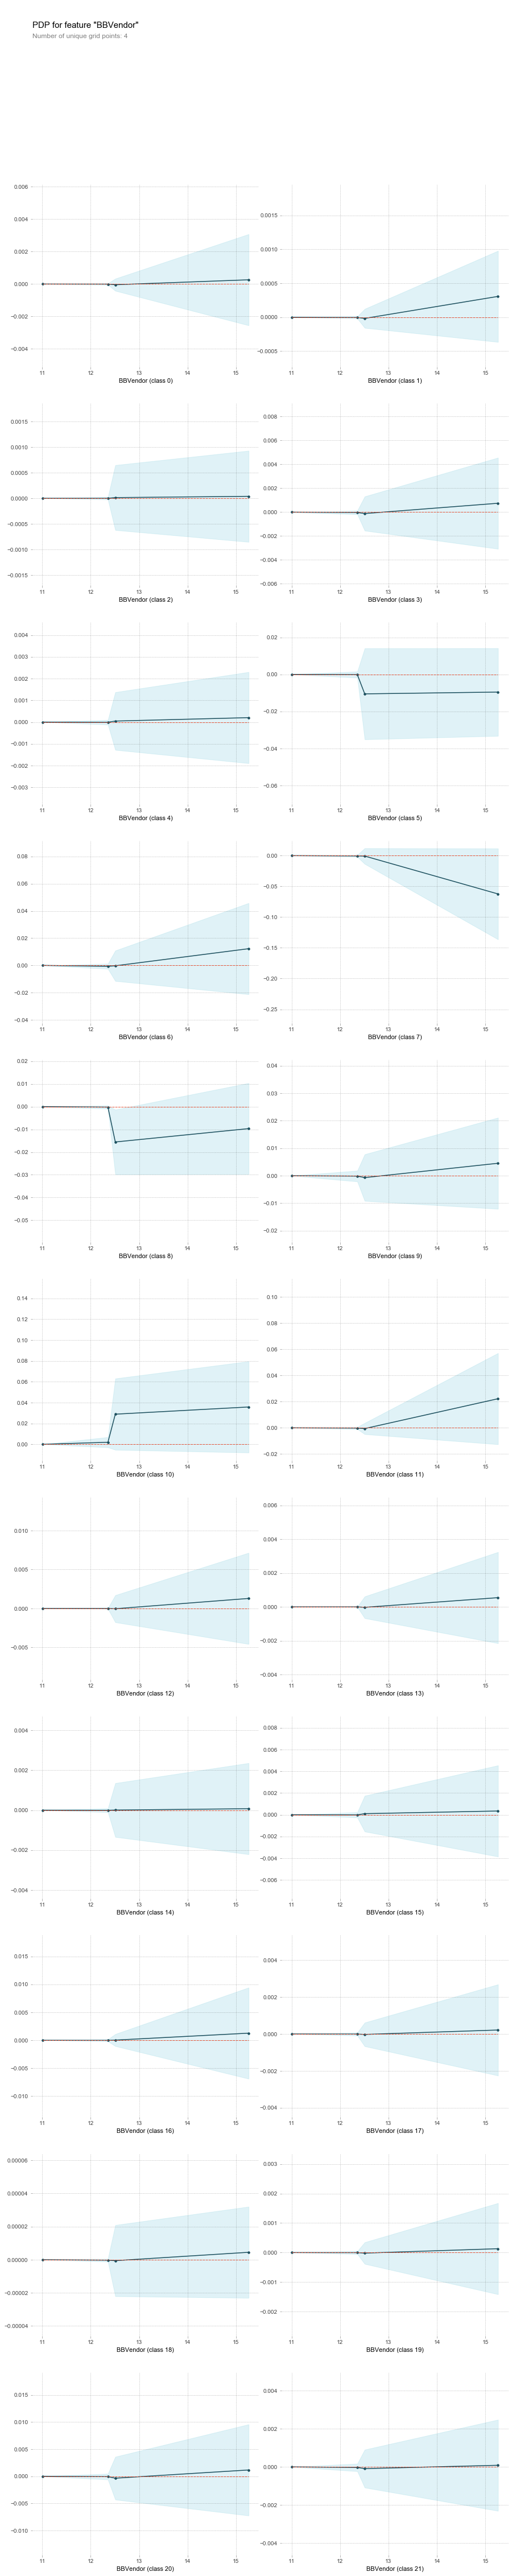

In [108]:
#X_train_transformed = pipe3[0].transform(X_train)

# we have to store this because onehot encoding changes the number of columns in the dataset
X_train_cols = X_train_transformed.columns

pdp_BBVendor = pdp.pdp_isolate(
    # this is the model with the predictions
    model = pipe3[1], 
    
    # this is the final dataset THAT'S BEEN TRANSFORMED FOR THE MODEL
    # we are using the training set since that is what our model was fit on
    dataset = pipe3[0].transform(X_train), 
    
    # column names from the transformed training set
    model_features = X_train_cols, 
    
    # column label
    feature = 'BBVendor',
)

# this part is just for formatting
fig, axes = pdp.pdp_plot(pdp_BBVendor, 'BBVendor')


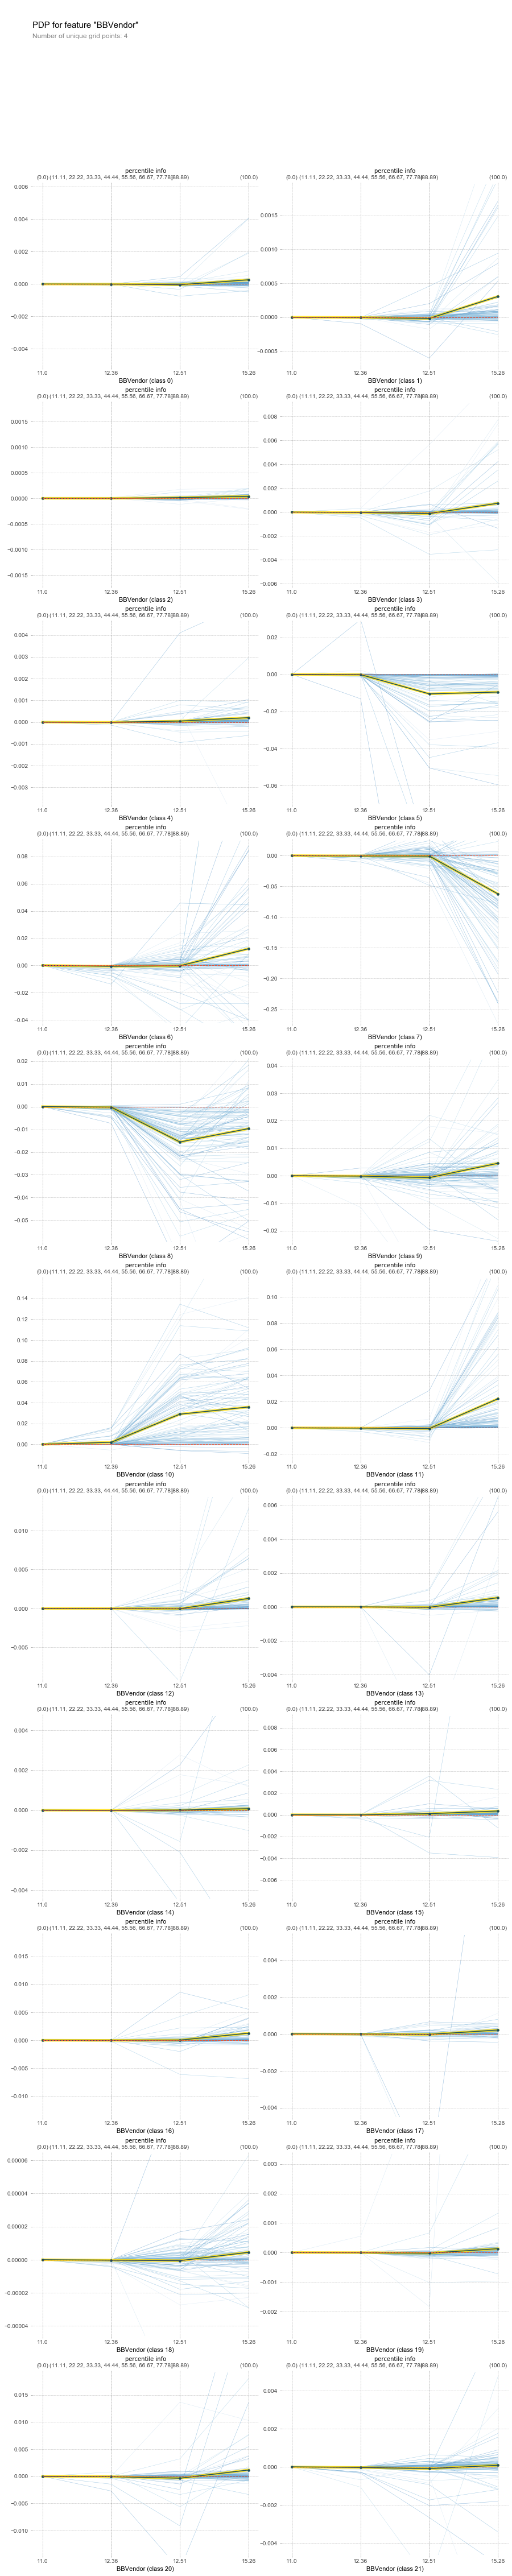

In [109]:
fig, axes = pdp.pdp_plot(
    pdp_BBVendor, 'BBVendor', plot_lines=True, frac_to_plot=100, x_quantile=True, 
 show_percentile=True
)

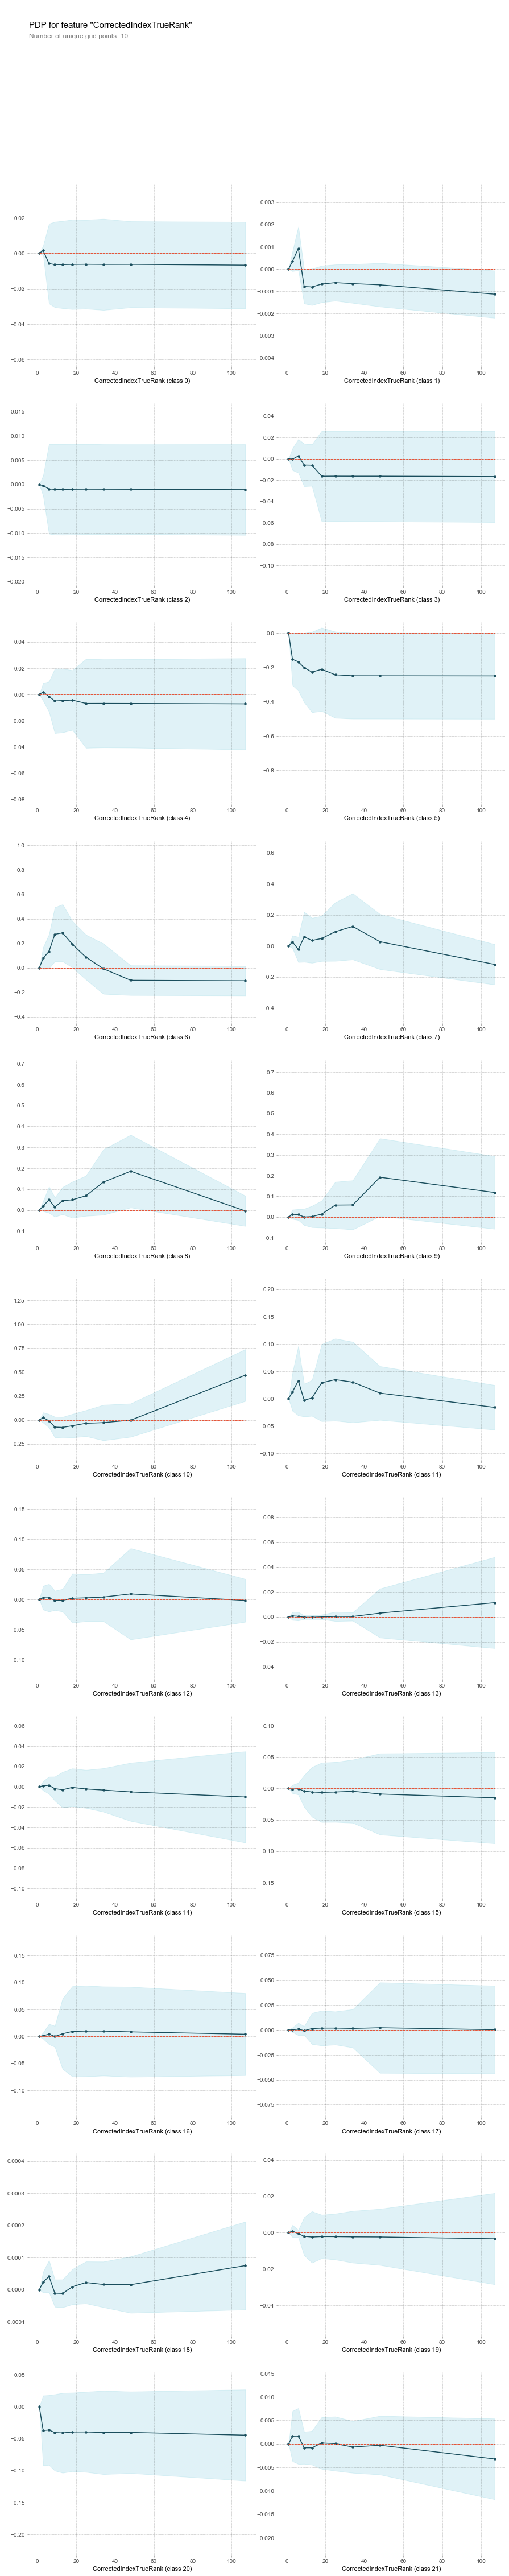

In [112]:
X_train_cols = X_train_transformed.columns

pdp_CorrectedIndexTrueRank = pdp.pdp_isolate(
    # this is the model with the predictions
    model = pipe3[1], 
    
    # this is the final dataset THAT'S BEEN TRANSFORMED FOR THE MODEL
    # we are using the training set since that is what our model was fit on
    dataset = pipe3[0].transform(X_train), 
    
    # column names from the transformed training set
    model_features = X_train_cols, 
    
    # column label
    feature = 'CorrectedIndexTrueRank',
)

# this part is just for formatting
fig, axes = pdp.pdp_plot(pdp_CorrectedIndexTrueRank, 'CorrectedIndexTrueRank')


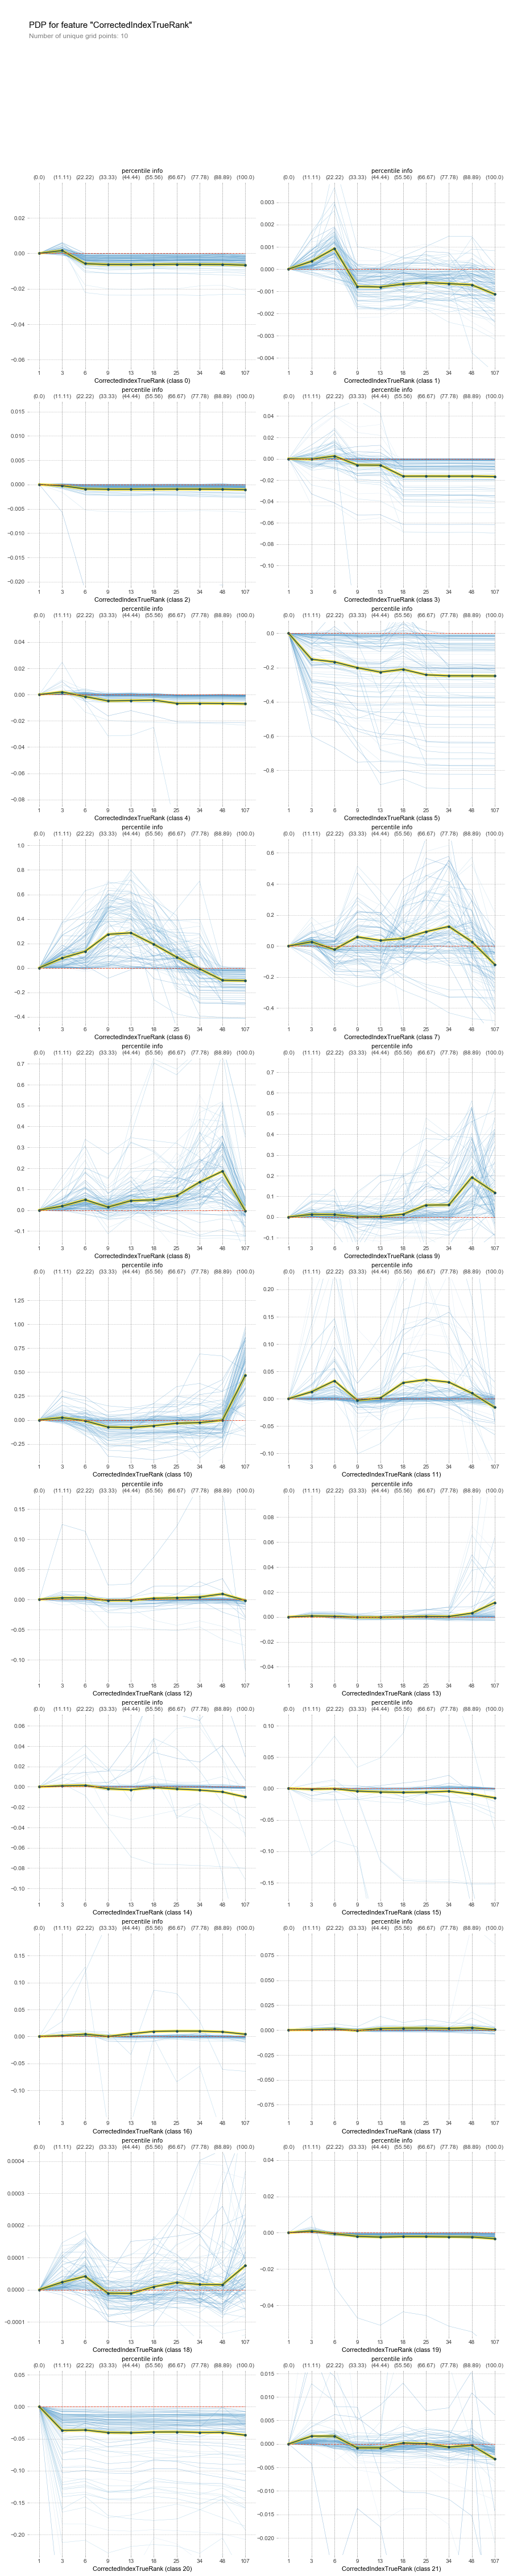

In [114]:
fig, axes = pdp.pdp_plot(
    pdp_CorrectedIndexTrueRank, 'CorrectedIndexTrueRank', plot_lines=True, frac_to_plot=100, x_quantile=True, 
 show_percentile=True
)

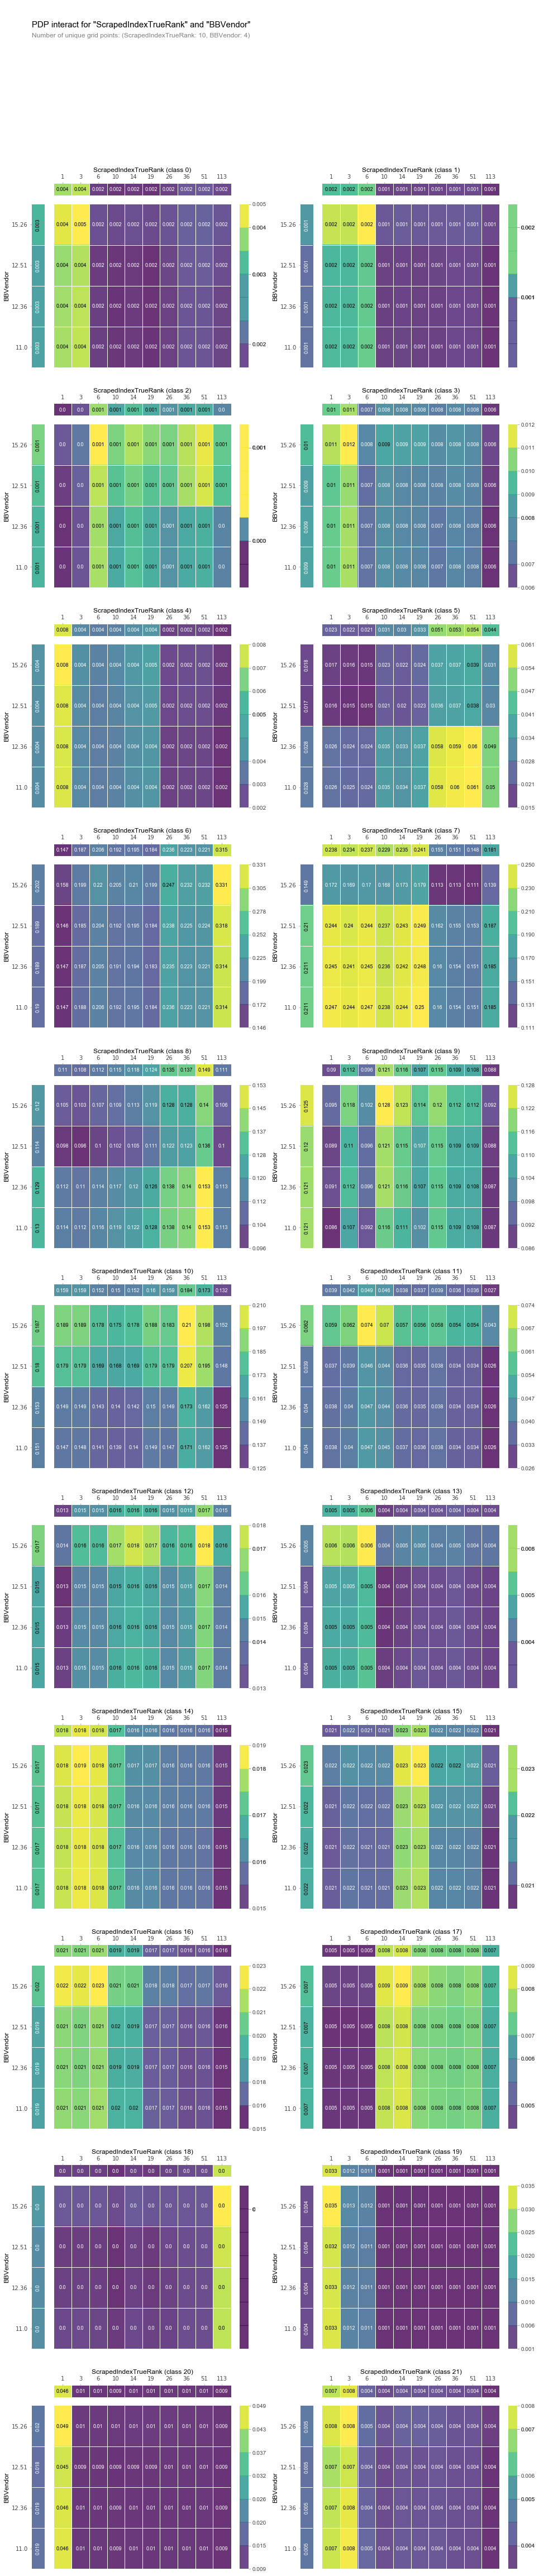

In [23]:
inter_rf = pdp.pdp_interact(
    model = pipe1[1], dataset = X_train_transformed, model_features=X_train_transformed.columns, 
    # you would list the name of columns you want to study here
    features=['ScrapedIndexTrueRank', 'BBVendor']
)

fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['ScrapedIndexTrueRank', 'BBVendor'], x_quantile=True, plot_type='grid', plot_pdp=True
)


In [126]:
estimators = [100, 200, 300, 400]
max_depth  = [3, 4]
sub_sample = [0.8, 0.6] # this is the amount of samples to randomly sample in each round
learning_rate = [0.1, 0.2]
cv_scores  = []

# do a training loop
for estimator in estimators:
    for depth in max_depth:
        for sample in sub_sample:
            for rate in learning_rate:
                print(f"Fitting new training loop for rounds: {estimator}, depth: {depth}, sampling rate: {sample}, rate: {rate}")
                pipe3[-1].set_params(n_estimators = estimator, 
                                    max_depth = depth, 
                                    subsample = sample,
                                    learning_rate = rate)
                scores = get_model_scores(pipe3, X_train, y_train, X_test, y_test)
                cv_scores.append((scores['train_score'], scores['val_score'], estimator, depth, sample, rate))

Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 100, depth: 3, sampling rate: 0.6, rate: 0.2
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 100, depth: 4, sampling rate: 0.6, rate: 0.2
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8, rate: 0.1
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.8, rate: 0.2
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6, rate: 0.1
Fitting new training loop for rounds: 200, depth: 3, sampling rate: 0.6, rate: 0.2
Fitt

In [127]:
max(cv_scores, key = lambda x: x[1])

(0.9995517705064993, 0.8413978494623656, 400, 4, 0.8, 0.2)

In [128]:
te  = ce.TargetEncoder()

pipe3 = make_pipeline(te, mod)

In [156]:
pipe3[-1].set_params(n_estimators = 400, max_depth = 4, sub_sample = 0.8, learning_rate = 0.2)

[22:17:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              sub_sample=0.8, subsample=0.6, tree_method='exact',
              validate_parameters=1, ...)

In [158]:
pred3 = pipe3.predict(X_train)

In [159]:
pipe3.predict_proba(X_train)

array([[6.2184954e-05, 7.4594405e-05, 4.0835107e-06, ..., 3.0411406e-06,
        1.9215697e-06, 1.3123320e-05],
       [2.0507794e-06, 6.9172597e-07, 4.3645232e-06, ..., 2.4757419e-06,
        9.3663107e-07, 9.4548222e-06],
       [2.3603034e-05, 7.6865595e-05, 1.2977622e-04, ..., 6.5993823e-05,
        1.9091674e-05, 1.1415270e-05],
       ...,
       [7.7983877e-03, 3.5384108e-04, 4.4485644e-04, ..., 1.3010576e-03,
        1.0916507e-03, 5.6475122e-03],
       [3.0253113e-06, 1.0161157e-05, 3.5795408e-06, ..., 4.6360969e-06,
        1.1875094e-06, 4.1167175e-05],
       [1.8110992e-04, 2.1227617e-04, 1.1892978e-05, ..., 8.7780845e-06,
        5.4809193e-06, 5.4020446e-05]], dtype=float32)

In [160]:
pred3 = pd.DataFrame(pred3)

In [ ]:
#Part 3 Dashboard Application (This part will be in different files.)